# 2016 US Bike Share Activity Snapshot

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing Your Own Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction

Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I performed an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I compared the system usage between three large cities: New York City, Chicago, and Washington, DC. I also explored if there were any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions

Before looking at the bike sharing data, you should start by asking questions you might want to understand about the bike share data. Consider, for example, if you were working for Motivate. What kinds of information would you want to know about in order to make smarter business decisions? If you were a user of the bike-share service, what factors might influence how you would want to use the service?

What is the utility rate of these bikes as in how many hours in a day is each of them being used and how does it compare across the cities? What revenue total is each of the systems making?

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, we will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

If you visit these pages, you will notice that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. A random 2% sample of the original data is taken to make the exploration more manageable. 

Let's run the first code cell below to load some packages and functions that I'll be using in my analysis. Then, let us print out the first trip recorded from each of the cities (the second line of each data file).

In [1]:
## import all necessary packages and functions.
import csv # read and write csv files
from datetime import datetime # operations to parse dates
import pprint # use to print data structures like dictionaries in
                          # a nicer way than the base print function.

In [4]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    # print city name for reference
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## TODO: Use the csv library to set up a DictReader object. ##
        ## see https://docs.python.org/3/library/csv.html           ##
        trip_reader = csv.DictReader(f_in)
        ## TODO: Use a function on the DictReader object to read the     ##
        ## first trip from the data file and store it in a variable.     ##
        ## see https://docs.python.org/3/library/csv.html#reader-objects ##
        first_trip = next(trip_reader)
        pprint.pprint(first_trip)
        ## TODO: Use the pprint library to print the first trip. ##
        ## see https://docs.python.org/3/library/pprint.html     ##
            
    # output city name and first trip for later testing
    return (city, first_trip)

# list of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv',]

# print the first trip from each file, store in dictionary
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

If everything has been filled out correctly, you should see below the printout of each city name (which has been parsed from the data file name) that the first trip has been parsed in the form of a dictionary. Setting up a `DictReader` object enables the first row of the data file is normally interpreted as column names. Every other row in the data file will use those column names as keys, as a dictionary is generated for each row.

This will be useful since we can refer to quantities by an easily-understandable label instead of just a numeric index. For example, if we have a trip stored in the variable `row`, then we would rather get the trip duration from `row['duration']` instead of `row[0]`.

<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

Next, I will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. Use the start time of the trip to obtain these values. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not. The [`datetime`](https://docs.python.org/3/library/datetime.html) package will be very useful here to make the needed conversions.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, you will convert the Washington labels to match the other two.

Next, lets complete the helper functions for above tasks.

In [5]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes.
    
    Remember that Washington is in terms of milliseconds while Chicago and NYC
    are in terms of seconds. 
    
    HINT: The csv module reads in all of the data as strings, including numeric
    values. You will need a function to convert the strings into an appropriate
    numeric type when making your transformations.
    see https://docs.python.org/3/library/functions.html
    """
    # YOUR CODE HERE
    if city == "Washington":
        duration = float(datum["Duration (ms)"])/(1000*60)
    else:
        duration = float(datum['tripduration'])/60
    
    
    return duration


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 13.9833,
         'Chicago': 15.4333,
         'Washington': 7.1231}

for city in tests:
    assert abs(duration_in_mins(example_trips[city], city) - tests[city]) < .001

In [6]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    
    Remember that NYC includes seconds, while Washington and Chicago do not.
    
    HINT: You should use the datetime module to parse the original date
    strings into a format that is useful for extracting the desired information.
    see https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
    """
    
    # YOUR CODE HERE
    if city == "NYC":
        cuttime = datetime.strptime(datum['starttime'], "%m/%d/%Y %X")
    elif city == "Chicago":
        cuttime = datetime.strptime(datum['starttime'], "%m/%d/%Y %H:%M")
    else:
        cuttime = datetime.strptime(datum['Start date'], "%m/%d/%Y %H:%M")
        
    month = int(cuttime.strftime("%m"))
    day_of_week = cuttime.strftime("%A")
    hour = int(cuttime.strftime("%H"))
    # print (city, month,hour,day_of_week)
    return (month, hour, day_of_week)


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': (1, 0, 'Friday'),
         'Chicago': (3, 23, 'Thursday'),
         'Washington': (3, 22, 'Thursday')}

for city in tests:
    assert time_of_trip(example_trips[city], city) == tests[city]

In [8]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    
    Remember that Washington has different category names compared to Chicago
    and NYC. 
    """

    
    if city == "Washington":
        user = datum['Member Type']
        if user == "Registered":
            user_type = "Subscriber"
        else:
            user_type = "Customer"
    else:
        user_type = datum['usertype']
    return user_type


# Some tests to check that your code works. There should be no output if all of
# the assertions pass. The `example_trips` dictionary was obtained from when
# you printed the first trip from each of the original data files.
tests = {'NYC': 'Customer',
         'Chicago': 'Subscriber',
         'Washington': 'Subscriber'}

for city in tests:
    assert type_of_user(example_trips[city], city) == tests[city]

Next, let us use the helper functions I wrote above to create a condensed data file for each city consisting only of the data fields indicated above.

In [9]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        # set up csv DictWriter object - writer requires column names for the
        # first row as the "fieldnames" argument
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## TODO: set up csv DictReader object ##
        trip_reader = csv.DictReader(f_in)

        # collect data from and process each row
        for row in trip_reader:
            # set up a dictionary to hold the values for the cleaned and trimmed
            # data point
            new_point = {}

            ## TODO: use the helper functions to get the cleaned data from  ##
            ## the original data dictionaries.                              ##
            ## Note that the keys for the new_point dictionary should match ##
            ## the column names set in the DictWriter object above.         ##
            new_point["duration"] = duration_in_mins(row, city)
            new_point["user_type"] = type_of_user(row, city)
            new_point["month"], new_point["hour"], new_point["day_of_week"] = time_of_trip(row, city)

            ## TODO: write the processed information to the output file.     ##
            ## see https://docs.python.org/3/library/csv.html#writer-objects ##
            trip_writer.writerow(new_point)
            

In [10]:
# Run this cell to check your work
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Let us start exploring the data. 

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts. The first cell below contains a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers. The second cell runs this function on the example Bay Area data in the `/examples/` folder. Modify the cells to answer the question below.

Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

City with maximum trips is: NYC and the number of trips are 276798
City with maximum Subscriber Proportion is: Chicago and the proportion is 0.238
City with maximum Customer Proportion is: NYC and the proportion is 0.89

In [11]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        # tally up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        # compute total number of rides
        n_total = n_subscribers + n_customers
        
        # return tallies as a tuple
        return(n_subscribers, n_customers, n_total)

In [12]:
city_file = {'Washington':'./data/Washington-2016-Summary.csv',
             'Chicago':'./data/Chicago-2016-Summary.csv',
             'NYC':'./data/NYC-2016-Summary.csv'}

from collections import defaultdict
city_condensedData = defaultdict(dict)
for city, file_name in city_file.items():
    # print (city, file_name)
    subscriber, customer, total = number_of_trips(file_name)
    # print (subscriber,customer,total)
    city_condensedData[city]['n_total'] = total
    city_condensedData[city]['n_customers'] = subscriber
    city_condensedData[city]['n_subscribers'] = customer

max_customer_prop = 0
max_subscriber_prop = 0
max_trips = 0
for city, data in city_condensedData.items():
    n_customerprop = data['n_customers']/data['n_total']
    n_subscriberprop = data['n_subscribers']/data['n_total']
    if data['n_total'] > max_trips:
        max_trips = data['n_total']
        max_customer_city = city
    if n_customerprop > max_customer_prop:
        max_customer_prop = n_customerprop
        max_customerprop_city = city
    if n_subscriberprop > max_subscriber_prop:
        max_subscriber_prop = n_subscriberprop
        max_subscriberprop_city = city
        
#print("City with maximum trips is: {} and the number of trips are {}".format(max_customer_city, max_trips))
#print("City with maximum Subscriber Proportion is: {} and the proportion is {}".format(max_subscriberprop_city, max_subscriber_prop))
#print("City with maximum Customer Proportion is: {} and the proportion is {}".format(max_customerprop_city, max_customer_prop))
    
data_file = './examples/BayArea-Y3-Summary.csv'
print(number_of_trips(data_file))

(5666, 633, 6299)


Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?



In [13]:
def trip_duration_summary(filename):
    """
    This function reads in a file with trip data and reports the trip duration summary
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_trips_charged = 0
        n_trips_free = 0
        duration_sum = 0
        # tally up ride types
        for row in reader:
            duration_sum += float(row['duration'])
            if float(row['duration']) > 30:
                n_trips_charged += 1
            else:
                n_trips_free += 1
        
        # compute total number of rides
        n_total = n_trips_charged + n_trips_free
        n_trips_chargedprop = n_trips_charged/n_total
        avg_trip_duration = duration_sum/n_total
        # return tallies as a tuple
        return(n_trips_chargedprop, avg_trip_duration)


In [14]:
## Here we get the duration summary from each cityfile and print it
for city, file_name in city_file.items():
    # print (city, file_name)
    chargedprop, avg_duration = trip_duration_summary(file_name)
    # print (subscriber,customer,total)
    print("The average trip duration for {} is: {:0.2f} minutes and the proportion of trips that are longer than 30 minutes are {:0.2f}".format(city, avg_duration, chargedprop))

#data_file = './examples/BayArea-Y3-Summary.csv'
#print(trip_duration_summary(data_file))


The average trip duration for Washington is: 18.93 minutes and the proportion of trips that are longer than 30 minutes are 0.11
The average trip duration for Chicago is: 16.56 minutes and the proportion of trips that are longer than 30 minutes are 0.08
The average trip duration for NYC is: 15.81 minutes and the proportion of trips that are longer than 30 minutes are 0.07


Let us dig deeper into the question of trip duration based on ridership. Choose one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

The average trip duration for Washington in total is: 18.93 minutes and out of this, the customer trip duration is 41.68 minutes and the subscriber trip duration is 12.53 minutes
The average trip duration for Chicago in total is: 16.56 minutes and out of this, the customer trip duration is 30.98 minutes and the subscriber trip duration is 12.07 minutes
The average trip duration for NYC in total is: 15.81 minutes and out of this, the customer trip duration is 32.78 minutes and the subscriber trip duration is 13.68 minutes

In [15]:
## consider revising some of your previous code to    ##
## make use of functions for reusability.                              ##
##                                                      ##
def trip_duration_summary_more(filename):
    """
    This function reads in a file with trip data and reports the trip duration summary in some more detail than previous one.
    """
    with open(filename, 'r') as f_in:
        # set up csv reader object
        reader = csv.DictReader(f_in)
        
        # initialize count variables
        n_trips_subscriber = 0
        trips_subscriber_durationsum = 0
        trips_customer_durationsum = 0
        n_trips_customer = 0
        duration_sum = 0
        # tally up ride types
        for row in reader:
            duration_sum += float(row['duration'])
            if row['user_type'] == 'Subscriber':
                n_trips_subscriber += 1
                trips_subscriber_durationsum += float(row['duration'])
            else:
                n_trips_customer += 1
                trips_customer_durationsum += float(row['duration'])
        
        # compute total number of rides
        n_total = n_trips_customer + n_trips_subscriber
        avg_customer_tripduration = trips_customer_durationsum/n_trips_customer
        avg_subscriber_tripduration = trips_subscriber_durationsum/n_trips_subscriber
        avg_trip_duration = duration_sum/n_total
        # return tallies as a tuple
        return(avg_customer_tripduration,avg_subscriber_tripduration,avg_trip_duration)


                                    ##
## Here we get the duration summary from each cityfile and print it
for city, file_name in city_file.items():
    customer_dur, subscriber_dur, total_dur = trip_duration_summary_more(file_name)
    print("The average trip duration for {} in total is: {:0.2f} minutes and out of this, the customer trip duration is {:0.2f} minutes and the subscriber trip duration is {:0.2f} minutes".format(city, total_dur, customer_dur, subscriber_dur))

#data_file = './examples/BayArea-Y3-Summary.csv'
#print(trip_duration_summary_more(data_file))


The average trip duration for Washington in total is: 18.93 minutes and out of this, the customer trip duration is 41.68 minutes and the subscriber trip duration is 12.53 minutes
The average trip duration for Chicago in total is: 16.56 minutes and out of this, the customer trip duration is 30.98 minutes and the subscriber trip duration is 12.07 minutes
The average trip duration for NYC in total is: 15.81 minutes and out of this, the customer trip duration is 32.78 minutes and the subscriber trip duration is 13.68 minutes


<a id='visualizations'></a>
### Visualizations

The last set of values that you computed should have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, a new library will be introduced here, `matplotlib`. Run the cell below to load the library and to generate an example plot.

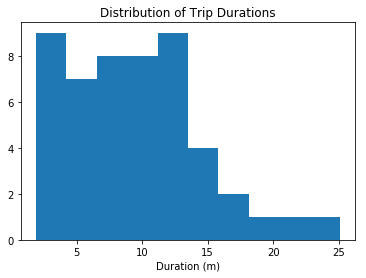

In [16]:
# load library
import matplotlib.pyplot as plt
%matplotlib inline 

# example histogram, data taken from bay area sample
data = [ 7.65,  8.92,  7.42,  5.50, 16.17,  4.20,  8.98,  9.62, 11.48, 14.33,
        19.02, 21.53,  3.90,  7.97,  2.62,  2.67,  3.08, 14.40, 12.90,  7.83,
        25.12,  8.30,  4.93, 12.43, 10.60,  6.17, 10.88,  4.78, 15.15,  3.53,
         9.43, 13.32, 11.72,  9.85,  5.22, 15.10,  3.95,  3.17,  8.78,  1.88,
         4.55, 12.68, 12.38,  9.78,  7.63,  6.45, 17.38, 11.90, 11.52,  8.63,]
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

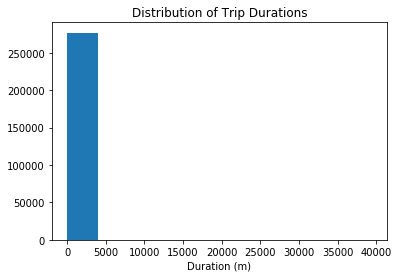

In [17]:
## Use this and additional cells to collect all of the trip times as a list ##
## and then use pyplot functions to generate a histogram of trip times.     ##
## I had chosen all the cities in 4c, in this one I choose NYC to do the analysis##
import matplotlib.pyplot as plt
%matplotlib inline 

file_NYCname = './data/NYC-2016-Summary.csv'
with open(file_NYCname, 'r') as f_in:
    # set up csv reader object
    reader = csv.DictReader(f_in)
        
    data_NYC = []
    i=0
    # initialize count variables
    for row in reader:
        data_NYC.append(float(row['duration']))
        i+=1
    plt.hist(data_NYC)
    plt.title('Distribution of Trip Durations')
    plt.xlabel('Duration (m)')
    plt.show()





If you followed the use of the `.hist()` and `.show()` functions exactly like in the example, you're probably looking at a plot that's completely unexpected. The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. Take a look at the duration values on the x-axis. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, let us use additional parameters with the `.hist()` function to limit the range of data that is plotted. 

The graphs are both skewed to the right. For customers, the peak is at 20 minutes approx. For subscribers, the peak is at 10 minutes.

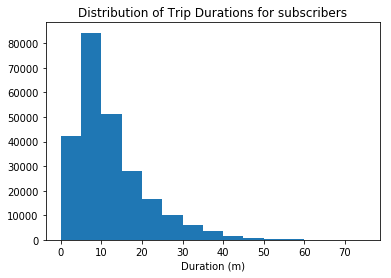

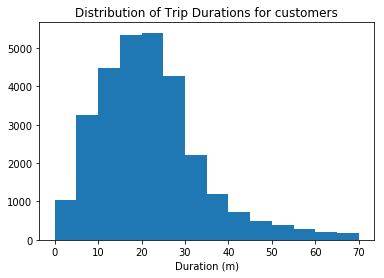

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline 

file_NYCname = './data/NYC-2016-Summary.csv'
with open(file_NYCname, 'r') as f_in:
    # set up csv reader object
    reader = csv.DictReader(f_in)
        
    data_NYC_subscriber = []
    data_NYC_customer = []
    i=0
    # initialize count variables
    for row in reader:
        if row['user_type'] == 'Subscriber':
            data_NYC_subscriber.append(float(row['duration']))
        else:
            data_NYC_customer.append(float(row['duration']))
            
    plt.hist(data_NYC_subscriber, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75])
    plt.title('Distribution of Trip Durations for subscribers')
    plt.xlabel('Duration (m)')
    #plt.xlim(0,75)
    plt.show()
    
    plt.hist(data_NYC_customer, bins=range(0,75,5))
    plt.title('Distribution of Trip Durations for customers')
    plt.xlabel('Duration (m)')
    plt.show()


<a id='eda_continued'></a>
## Performing Your Own Analysis

So far, we have only performed an initial exploration into the data available. We have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, you have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. Now let us continue the exploration in a different direction. 

During what time of day is the system used the most? Is there a difference in usage patterns for Subscribers and Customers?
As can be seen in the visualisations below: Customers use the bike system pretty much ina  bell shaped way across the day with peak hours being around 3 pm and almost no usage in the hours following midnight until 5.
As for subscribers, there are two peaks corresponding to 8 am and 5 pm which might indicate working hours being peak times for these users but we might want to do further analysis to be sure of this. for example we could plot them by weekday and if the peak is low for weekend for subscribers, that will support this observation too. 

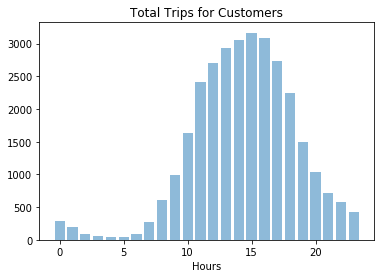

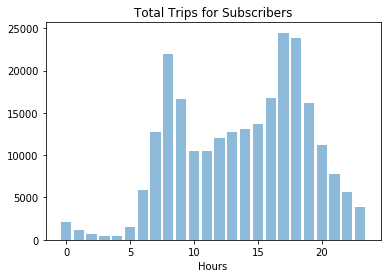

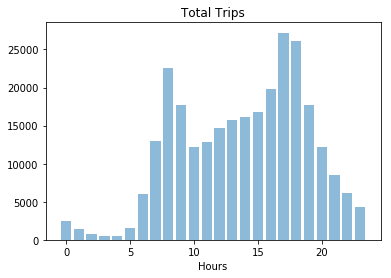

In [19]:
## I will continue using NYC as the chosen city and do the analysis for this city only ##

## To answer the question on what time of the day the system is used the most, I will pick the trip start time ##
## I will add all the trips that started in the same hour together and in a way this will return a list of number of trips ##
## arranged by the hour at which they started which indicates the number of trips per year in that particular hour##
## When compared, these numbers will tell which hours are more preferred to others. While doing so, I will prepare the list ##
## separately for subscribers and customers and then add each of the individual list to get one list overall. This will tell ##
## how the usage pattern differs among these two groups ##

import matplotlib.pyplot as plt
%matplotlib inline 

file_NYCname = './data/NYC-2016-Summary.csv'
with open(file_NYCname, 'r') as f_in:
    # set up csv reader object
    reader = csv.DictReader(f_in)
        
    hourlydata_NYC = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    hourlydata_NYCCustomer = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    hourydata_NYCSubscriber = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    # initialize count variables
    for row in reader:
        if row['user_type'] == 'Subscriber':
            hourydata_NYCSubscriber[int(row['hour'])] +=1
        else:
             hourlydata_NYCCustomer[int(row['hour'])] +=1 
        for i in range(24):
            hourlydata_NYC[i] = hourydata_NYCSubscriber[i] +  hourlydata_NYCCustomer[i]
    hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    plt.bar(hours, hourlydata_NYCCustomer, align='center', alpha=0.5)
    plt.title('Total Trips for Customers')
    plt.xlabel('Hours')
    plt.show()
    plt.bar(hours, hourydata_NYCSubscriber, align='center', alpha=0.5)
    plt.title('Total Trips for Subscribers')
    plt.xlabel('Hours')
    plt.show()
    plt.bar(hours, hourlydata_NYC, align='center', alpha=0.5)
    plt.title('Total Trips')
    plt.xlabel('Hours')
    plt.show()
    

<a id='conclusions'></a>
## Conclusions

This was a fun project to work on. Data Science can be used in so many diverse fields and let us have more fun exploring each of those options